# Proyecto 2 - Coronavirus

Este proyecto consiste en estimar un modelo SIR con datos de un país sobre el COVID-19.

In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Toolbox especial
import PDEparams as pde
# https://github.com/systemsmedicine/PDE_params

# I. Modelos iniciales

### Carga de Datos (Rusia)

De acuerdo a Google, la población de Rusia es

$$
N = 144.5 \text{ Millones}
$$

In [3]:
# Vamos a considerar la población mundial de Rusia
N = 144500000
# Estos son todos los datos con los que contamos
data = pd.read_csv('Russia_COVID.csv')
data.head()

,Fecha,Tiempo,Infectados_Acumulados,Recuperados_Acumulados,Muertes_Acumulados,Infectados,Recuperados,Muertos
0,1/31/20,0,2,0,0,2,0,0
1,2/1/2020,1,2,0,0,0,0,0
2,2/2/2020,2,2,0,0,0,0,0
3,2/3/2020,3,2,0,0,0,0,0
4,2/4/2020,4,2,0,0,0,0,0


## Defininimos el modelo SIR

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infectado -> Recuperado

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}
\end{align}
$$

Nota: En general es deseable que $\gamma\in(0,1)$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

Nota: Este modelo asumirá que $R$ es la población que no que fue infectada pero ya no puede volver a infectar. Por efectos de cómo tenemos los datos, nosotros vamos a considerar que estos serán los muertos más los recuperados.

#### Con infectados y recuperados

In [4]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            'R': data.Muertos + data.Recuperados 
})
datos.describe()

,t,I,R
count,312.000000,312.000000,312.000000
mean,155.500000,7906.926282,6354.214744
std,90.210864,7089.869411,6535.580611
min,0.000000,0.000000,0.000000
25%,77.750000,4218.500000,325.250000
50%,155.500000,6285.000000,5572.000000
75%,233.250000,9794.750000,8828.250000
max,311.000000,28701.000000,29627.000000


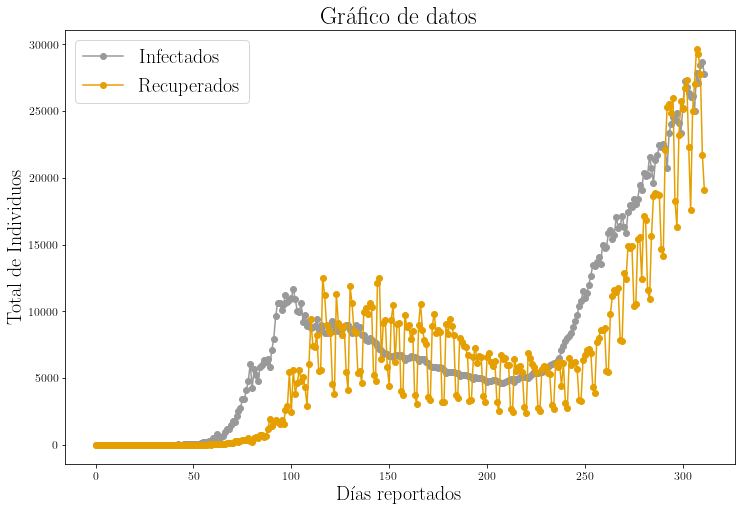

In [5]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [6]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado y una población susceptible de $N-1$.

In [7]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [8]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [9]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([144499999,         1,         0])

##### Encontrando los mejores parámetros

In [10]:
%%time
modelo_SIR.fit()

    $\beta$  $\gamma$
0  6.128695  6.150336
Wall time: 969 ms


In [11]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,6.128695,6.150336


In [12]:
modelo_SIR.best_error

96053238.10554346

#### Likelihood profiles

In [13]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 2min 55s


In [14]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,9.778188e+07
1,$\beta$,0.135135,9.776472e+07
2,$\beta$,0.270270,9.574744e+07
3,$\beta$,0.405405,9.774861e+07
4,$\beta$,0.540541,6.204895e+07
...,...,...,...
145,$\gamma$,9.459459,9.646472e+07
146,$\gamma$,9.594595,9.518076e+07
147,$\gamma$,9.729730,9.760246e+07
148,$\gamma$,9.864865,9.670536e+07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


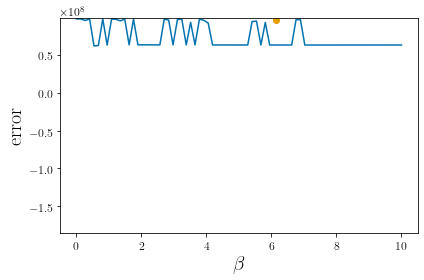

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


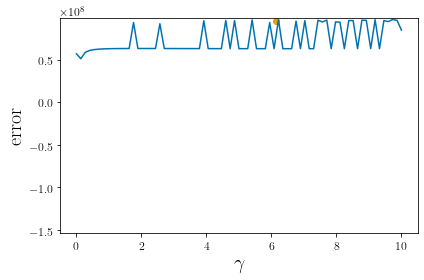

In [15]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [16]:
# Creamos un vector de valores iniciales
S0 = N - 1
I0 = 1
R0 = 0
iniciales = S0, I0, R0
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

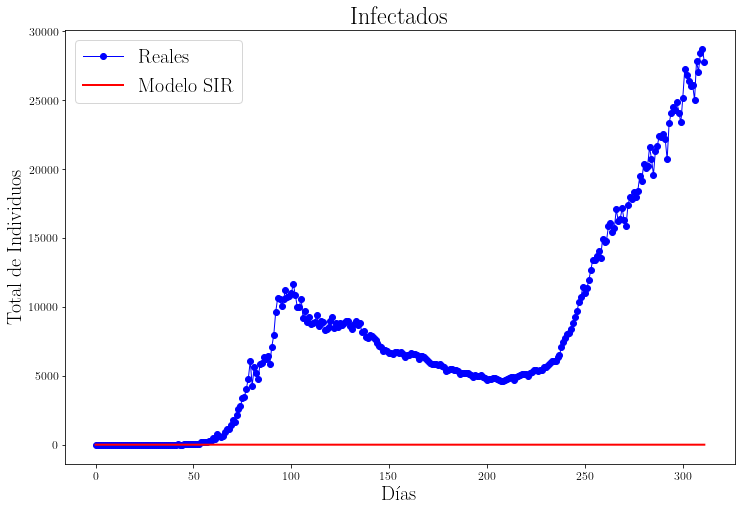

In [17]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Recuperados

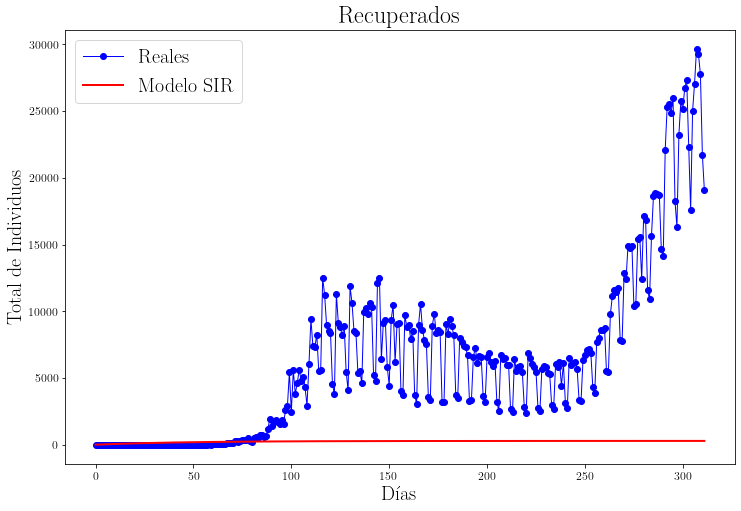

In [18]:
# Gráfica de los recuperados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.R, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, R, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Recuperados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

#### Con infectados únicamente

In [19]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            #'R': data.Muertos + data.Recuperados 
})
datos.describe()

,t,I
count,312.000000,312.000000
mean,155.500000,7906.926282
std,90.210864,7089.869411
min,0.000000,0.000000
25%,77.750000,4218.500000
50%,155.500000,6285.000000
75%,233.250000,9794.750000
max,311.000000,28701.000000


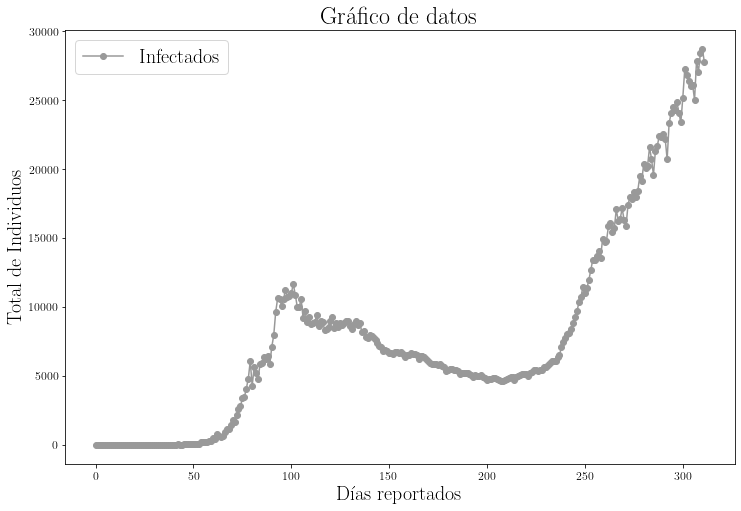

In [20]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
#plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [21]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado y una población susceptible de $N-1$.

In [22]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [23]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [24]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([144499999,         1,         0])

##### Encontrando los mejores parámetros

In [25]:
%%time
modelo_SIR.fit()

    $\beta$  $\gamma$
0  2.035587  1.997495
Wall time: 3.63 s


In [26]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,2.035587,1.997495


In [27]:
modelo_SIR.best_error

21476246.531065844

#### Likelihood profiles

In [28]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 3min 31s


In [29]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,1.126246e+08
1,$\beta$,0.135135,1.126246e+08
2,$\beta$,0.270270,1.126246e+08
3,$\beta$,0.405405,1.126246e+08
4,$\beta$,0.540541,1.126246e+08
...,...,...,...
145,$\gamma$,9.459459,1.126246e+08
146,$\gamma$,9.594595,1.126246e+08
147,$\gamma$,9.729730,1.117021e+08
148,$\gamma$,9.864865,1.126246e+08


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


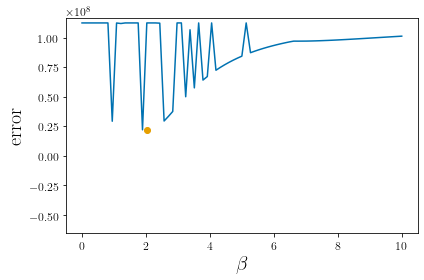

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


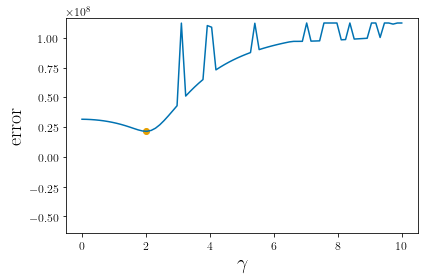

In [30]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [31]:
# Creamos un vector de valores iniciales
S0 = N - 1
I0 = 1
R0 = 0
iniciales = S0, I0, R0
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

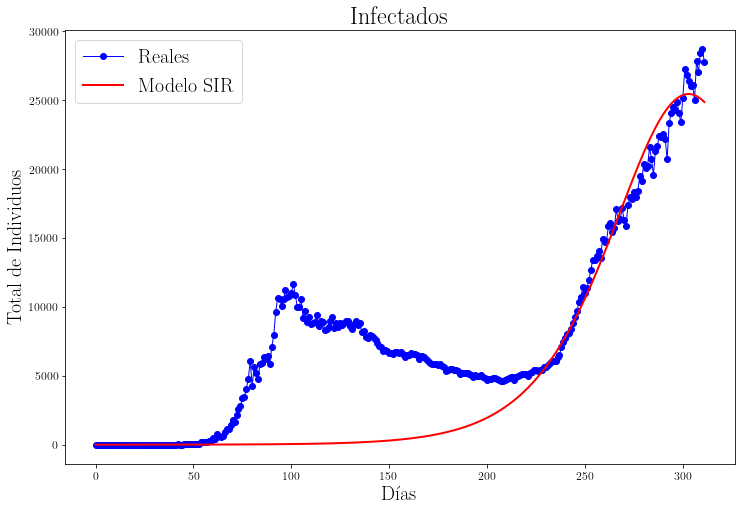

In [32]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

## Defininimos el modelo SIRD

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma I - \mu I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I\\
\frac{\mathrm{d} D}{\mathrm{d} t} &= \mu\,I
\end{align}$$

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}\\
\mu &= \text{Tasa de Mortalidad}
\end{align}
$$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

- $D :=$ Población Muerta

In [33]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            #'S': N - np.cumsum(data.Infectados) - (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados
            'R': data.Recuperados,
            # Muertos
            'D': data.Muertos
})
datos.describe()

,t,I,R,D
count,312.000000,312.000000,312.000000,312.000000
mean,155.500000,7906.926282,6216.003205,138.211538
std,90.210864,7089.869411,6409.222375,130.474647
min,0.000000,0.000000,0.000000,0.000000
25%,77.750000,4218.500000,290.500000,40.750000
50%,155.500000,6285.000000,5467.500000,116.000000
75%,233.250000,9794.750000,8653.000000,176.000000
max,311.000000,28701.000000,29084.000000,580.000000


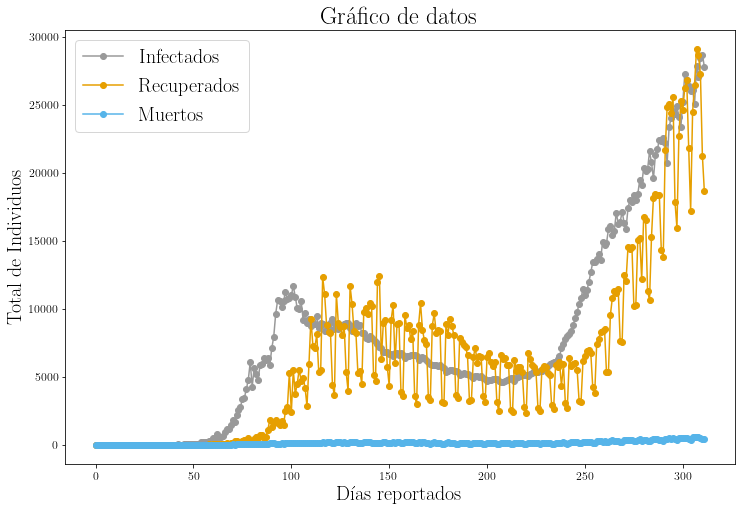

In [34]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.plot(datos.t, datos.D, '-o', label="Muertos")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [35]:
def sistema_SIR(z, t, beta, gamma,mu):
    
    S, I, R, D = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I - mu * D
    # dR/dt
    dRdt = gamma * I
    # dD/dt
    dDdt = mu * D
    
    return [dSdt,dIdt,dRdt,dDdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado, ningún muerto y una población susceptible de $N-1$.

In [36]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0
# Muerto inicial
def D0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [37]:
modelo_SIRD = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0,D0], bounds=[(0, 10), (0,10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$', r'$\mu$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [38]:
# Mostramos la condición Inicial
modelo_SIRD.initial_condition

array([144499999,         1,         0,         0])

##### Encontrando los mejores parámetros

In [39]:
%%time
modelo_SIRD.fit()

    $\beta$  $\gamma$     $\mu$
0  0.063384  0.029342  3.625749
Wall time: 6.81 s


In [40]:
modelo_SIRD.best_params

,$\beta$,$\gamma$,$\mu$
0,0.063384,0.029342,3.625749


In [41]:
modelo_SIRD.best_error

18169118.70083579

#### Likelihood profiles

In [42]:
%%time
modelo_SIRD.likelihood_profiles(npoints=50)



Wall time: 7min 2s


In [43]:
modelo_SIRD.result_profiles

,parameter,value,error
0,$\beta$,0.000000,6.407781e+07
1,$\beta$,0.204082,6.350145e+07
2,$\beta$,0.408163,4.047313e+07
3,$\beta$,0.612245,6.405950e+07
4,$\beta$,0.816327,6.070557e+07
...,...,...,...
145,$\mu$,9.183673,4.204125e+07
146,$\mu$,9.387755,6.250375e+07
147,$\mu$,9.591837,1.817015e+07
148,$\mu$,9.795918,6.073183e+07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


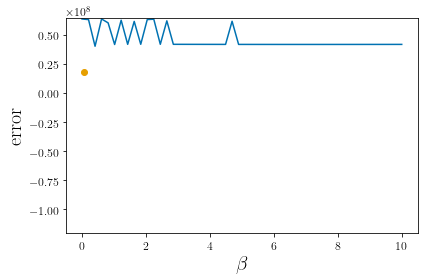

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


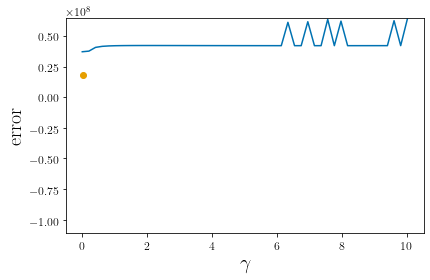

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


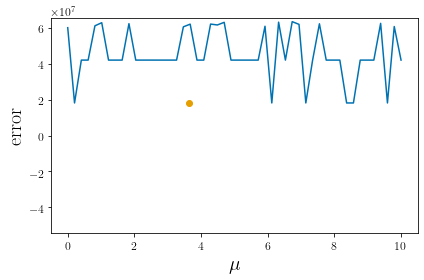

In [44]:
modelo_SIRD.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [45]:
# Creamos un vector de valores iniciales
S0 = N - 1
I0 = 1
R0 = 0
D0 = 0
iniciales = S0, I0, R0, D0
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIRD.best_params.iloc[0,0]
gamma = modelo_SIRD.best_params.iloc[0,1]
mu = modelo_SIRD.best_params.iloc[0,2]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma, mu))
S, I, R, D = ajustados.T

##### Infectados

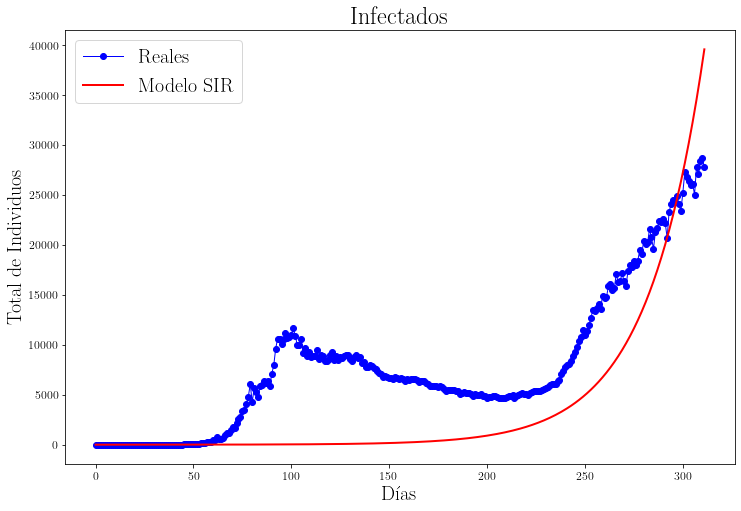

In [46]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Recuperados

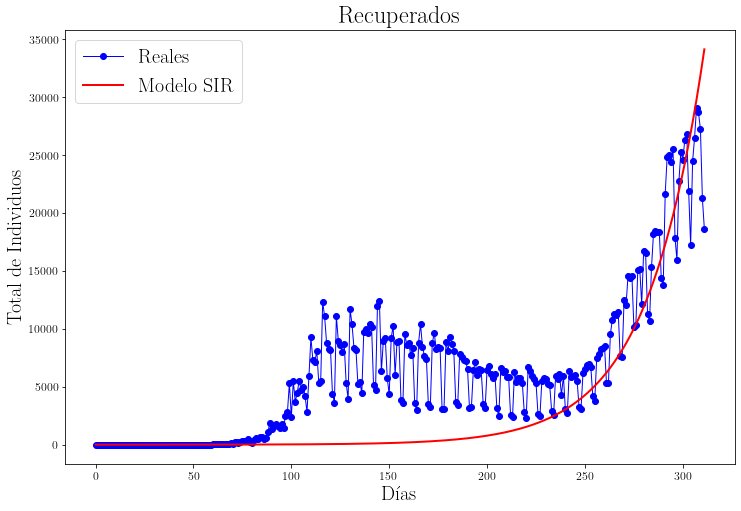

In [47]:
# Gráfica de los recuperados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.R, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, R, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Recuperados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Muertos

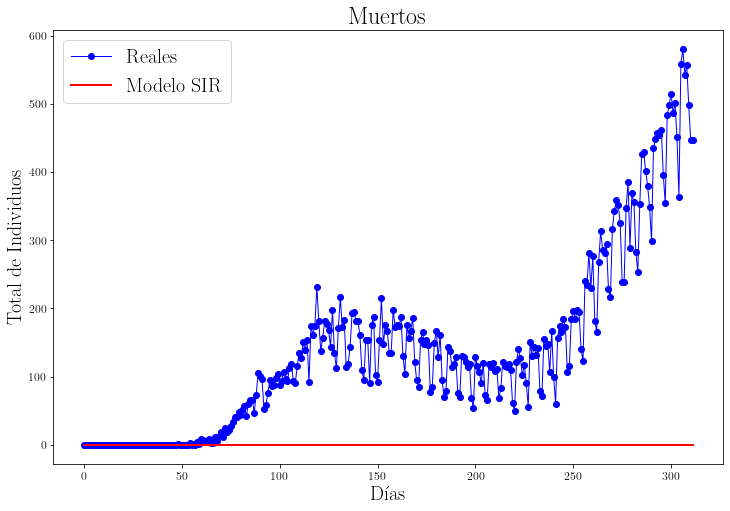

In [48]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.D, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, D, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Muertos')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

# II . Repetiremos todo el procedimiento anterior, escalando los datos.

### Carga de Datos (Rusia)

De acuerdo a Google, la población de Rusia es

$$
N = 144.5 \text{ Millones}
$$

In [49]:
# Vamos a considerar la población mundial de Rusia
N = 144500000
# Estos son todos los datos con los que contamos
data = pd.read_csv('Russia_COVID.csv')
data

,Fecha,Tiempo,Infectados_Acumulados,Recuperados_Acumulados,Muertes_Acumulados,Infectados,Recuperados,Muertos
0,1/31/20,0,2,0,0,2,0,0
1,2/1/2020,1,2,0,0,0,0,0
2,2/2/2020,2,2,0,0,0,0,0
3,2/3/2020,3,2,0,0,0,0,0
4,2/4/2020,4,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...
307,12/3/2020,307,2354934,1843526,41173,27829,29084,543
308,12/4/2020,308,2382012,1872214,41730,27078,28688,557
309,12/5/2020,309,2410462,1899474,42228,28450,27260,498
310,12/6/2020,310,2439163,1920744,42675,28701,21270,447


## Defininimos el modelo SIR

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infectado -> Recuperado

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}
\end{align}
$$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

Nota: Este modelo asumirá que $R$ es la población que no que fue infectada pero ya no puede volver a infectar. Por efectos de cómo tenemos los datos, nosotros vamos a considerar que estos serán los muertos más los recuperados.

#### Con infectados y recuperados

In [50]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            'R': data.Muertos + data.Recuperados 
})
# VAMOS A ESCALAR LOS DATOS
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
datos[['I', 'R']] = scaler.fit_transform(datos[['I', 'R']])
datos.describe()

,t,I,R
count,312.000000,312.000000,312.000000
mean,155.500000,0.275493,0.214474
std,90.210864,0.247025,0.220595
min,0.000000,0.000000,0.000000
25%,77.750000,0.146981,0.010978
50%,155.500000,0.218982,0.188072
75%,233.250000,0.341269,0.297980
max,311.000000,1.000000,1.000000


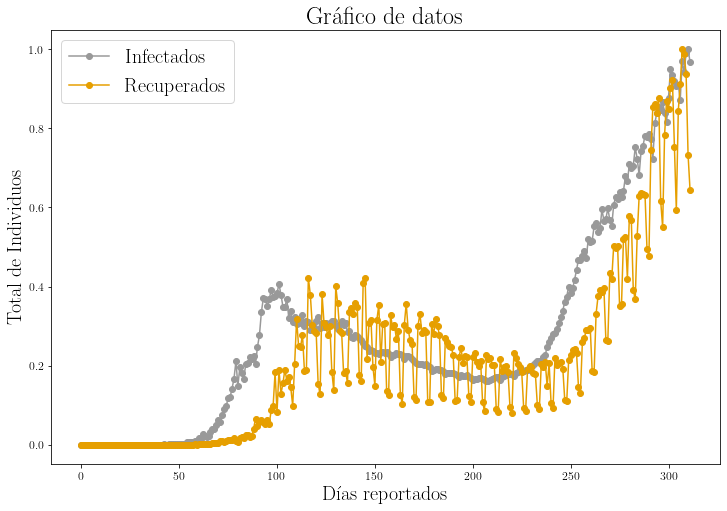

In [51]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [52]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado y una población susceptible de $N-1$.

In [53]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [54]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [55]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([144499999,         1,         0])

##### Encontrando los mejores parámetros

In [56]:
%%time
modelo_SIR.fit()

   $\beta$  $\gamma$
0      0.0  9.322188
Wall time: 1.29 s


In [57]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,0.0,9.322188


In [58]:
modelo_SIR.best_error

0.4011395347769452

#### Likelihood profiles

In [59]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 3min 56s


In [60]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,0.394164
1,$\beta$,0.135135,0.411951
2,$\beta$,0.270270,0.423307
3,$\beta$,0.405405,0.435087
4,$\beta$,0.540541,0.447672
...,...,...,...
145,$\gamma$,9.459459,0.401160
146,$\gamma$,9.594595,0.401252
147,$\gamma$,9.729730,0.401150
148,$\gamma$,9.864865,0.401144


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


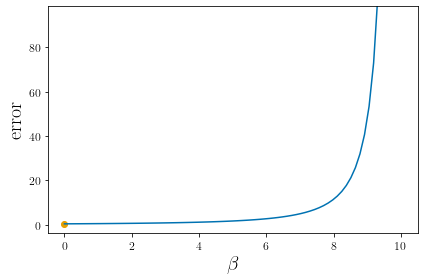

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


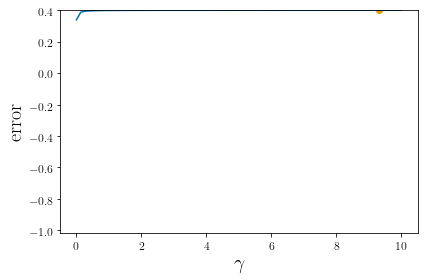

In [61]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [62]:
# Creamos un vector de valores iniciales
S0 = N - 1
I0 = 1
R0 = 0
iniciales = S0, I0, R0
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

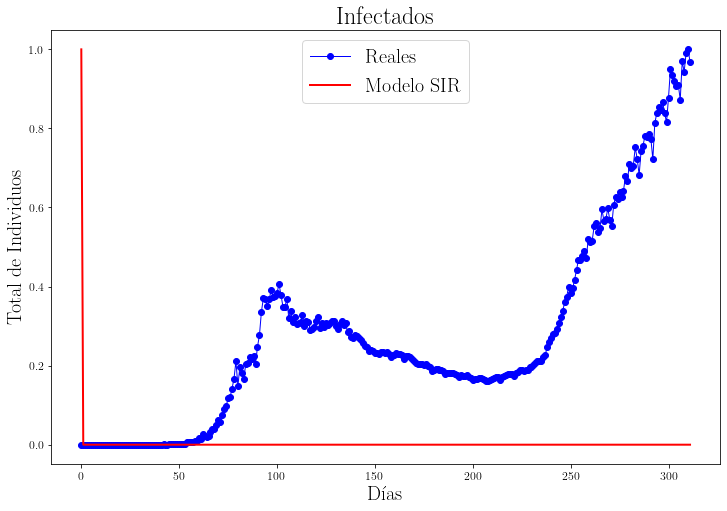

In [63]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Recuperados

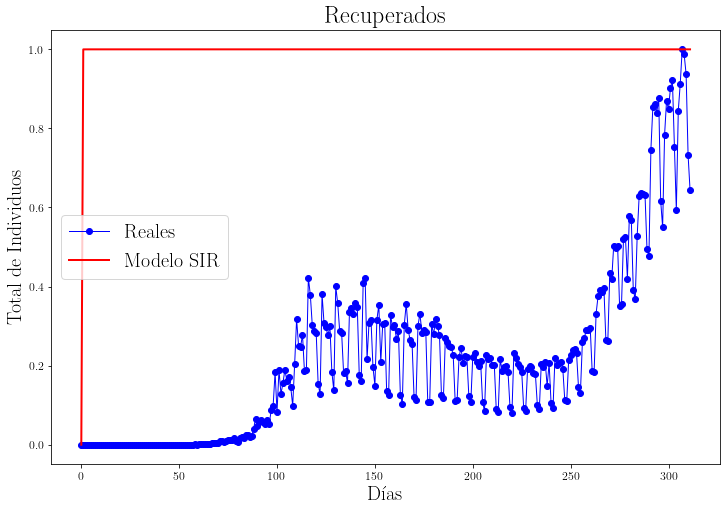

In [64]:
# Gráfica de los recuperados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.R, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, R, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Recuperados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

#### Con infectados únicamente

In [65]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            #'R': data.Muertos + data.Recuperados 
})
# VAMOS A ESCALAR LOS DATOS
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
datos[['I']] = scaler.fit_transform(datos[['I']])
datos.describe()

,t,I
count,312.000000,312.000000
mean,155.500000,0.275493
std,90.210864,0.247025
min,0.000000,0.000000
25%,77.750000,0.146981
50%,155.500000,0.218982
75%,233.250000,0.341269
max,311.000000,1.000000


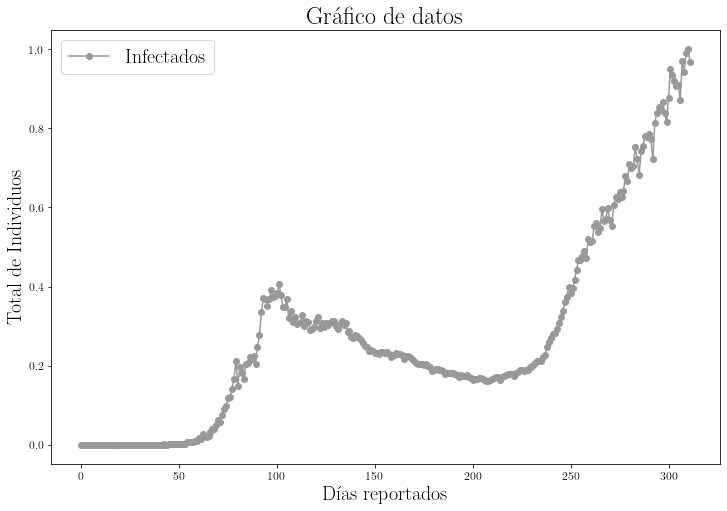

In [66]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
#plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [67]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado y una población susceptible de $N-1$.

In [68]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [69]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [70]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([144499999,         1,         0])

##### Encontrando los mejores parámetros

In [71]:
%%time
modelo_SIR.fit()

   $\beta$  $\gamma$
0  0.20919  9.424674
Wall time: 475 ms


In [72]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,0.20919,9.424674


In [73]:
modelo_SIR.best_error

0.13992696022429482

#### Likelihood profiles

In [74]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 2min 7s


In [75]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,0.139927
1,$\beta$,0.135135,0.139927
2,$\beta$,0.270270,0.139927
3,$\beta$,0.405405,0.139927
4,$\beta$,0.540541,0.139927
...,...,...,...
145,$\gamma$,9.459459,0.139927
146,$\gamma$,9.594595,0.139927
147,$\gamma$,9.729730,0.139927
148,$\gamma$,9.864865,0.139927


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


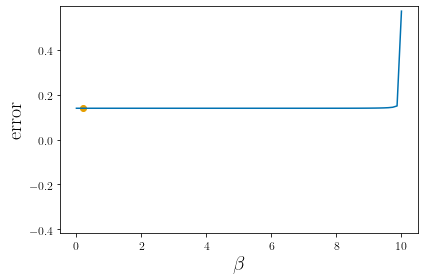

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


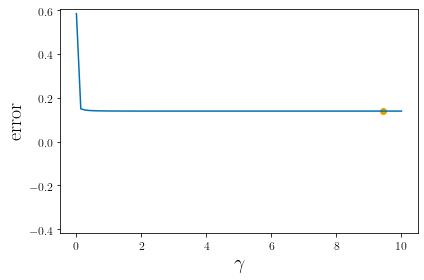

In [76]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [77]:
# Creamos un vector de valores iniciales
S0 = N - 1
I0 = 1
R0 = 0
iniciales = S0, I0, R0
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

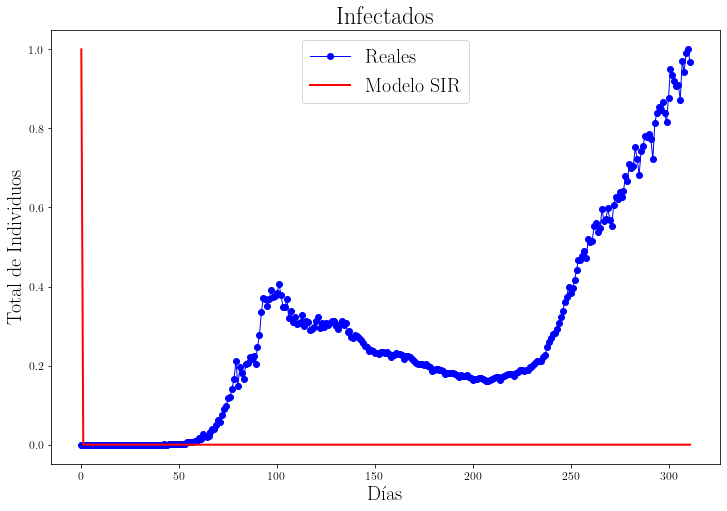

In [78]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

## Defininimos el modelo SIRD

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma I - \mu I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I\\
\frac{\mathrm{d} D}{\mathrm{d} t} &= \mu\,I
\end{align}$$

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}\\
\mu &= \text{Tasa de Mortalidad}
\end{align}
$$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

- $D :=$ Población Muerta

In [79]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': data.Tiempo,
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            #'S': N - np.cumsum(data.Infectados) - (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados
            'R': data.Recuperados,
            # Muertos
            'D': data.Muertos
})
# VAMOS A ESCALAR LOS DATOS
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
datos[['I', 'R', 'D']] = scaler.fit_transform(datos[['I', 'R', 'D']])
datos.describe()

,t,I,R,D
count,312.000000,312.000000,312.000000,312.000000
mean,155.500000,0.275493,0.213726,0.238296
std,90.210864,0.247025,0.220369,0.224956
min,0.000000,0.000000,0.000000,0.000000
25%,77.750000,0.146981,0.009988,0.070259
50%,155.500000,0.218982,0.187990,0.200000
75%,233.250000,0.341269,0.297518,0.303448
max,311.000000,1.000000,1.000000,1.000000


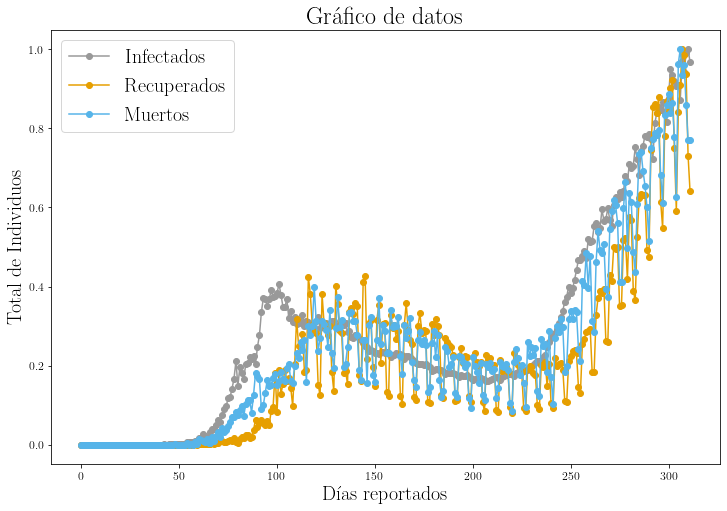

In [80]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.plot(datos.t, datos.D, '-o', label="Muertos")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [81]:
def sistema_SIR(z, t, beta, gamma,mu):
    
    S, I, R, D = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I - mu * D
    # dR/dt
    dRdt = gamma * I
    # dD/dt
    dDdt = mu * D
    
    return [dSdt,dIdt,dRdt,dDdt]

Vamos a definir los valores iniciales de nuestros datos. Para esto, consideramos un escenario donde al principio teníamos un infectado, ningún recuperado, ningún muerto y una población susceptible de $N-1$.

In [82]:
# Susceptible inicial
def S0():
    return N-1
# Infectado inicial
def I0():
    return 1
# Recuperado inicial
def R0():
    return 0
# Muerto inicial
def D0():
    return 0

Con base en todo lo anterior, ejectuamos nuestro modelo

In [83]:
modelo_SIRD = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0,D0], bounds=[(0, 10), (0,1), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$', r'$\mu$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1,2,3], outfunc=None)

In [84]:
# Mostramos la condición Inicial
modelo_SIRD.initial_condition

array([144499999,         1,         0,         0])

##### Encontrando los mejores parámetros

In [85]:
%%time
modelo_SIRD.fit()

   $\beta$  $\gamma$     $\mu$
0      0.0  0.003543  8.465426
Wall time: 8.65 s


In [86]:
modelo_SIRD.best_params

,$\beta$,$\gamma$,$\mu$
0,0.0,0.003543,8.465426


In [87]:
modelo_SIRD.best_error

0.14740050681450514

#### Likelihood profiles

In [88]:
%%time
modelo_SIRD.likelihood_profiles(npoints=50)



Wall time: 14min 44s


In [89]:
modelo_SIRD.result_profiles

,parameter,value,error
0,$\beta$,0.000000,0.147401
1,$\beta$,0.204082,0.457163
2,$\beta$,0.408163,0.815863
3,$\beta$,0.612245,1.933197
4,$\beta$,0.816327,8.946773
...,...,...,...
145,$\mu$,9.183673,0.147501
146,$\mu$,9.387755,0.147432
147,$\mu$,9.591837,0.147484
148,$\mu$,9.795918,0.147437


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


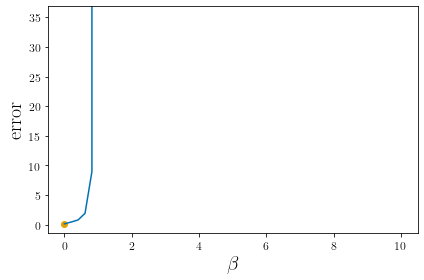

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


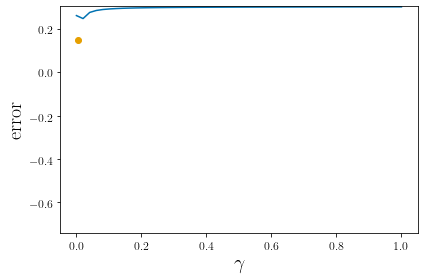

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


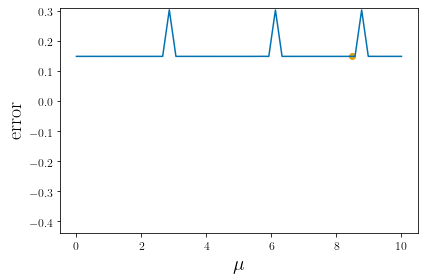

In [90]:
modelo_SIRD.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [91]:
# Creamos un vector de valores iniciales
S0 = N - 1
I0 = 1
R0 = 0
D0 = 0
iniciales = S0, I0, R0, D0
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIRD.best_params.iloc[0,0]
gamma = modelo_SIRD.best_params.iloc[0,1]
mu = modelo_SIRD.best_params.iloc[0,2]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma, mu))
S, I, R, D = ajustados.T

##### Infectados

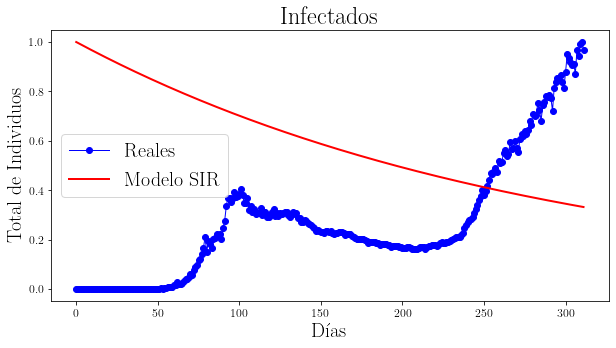

In [92]:
# Gráfica de los infectados
fig = plt.figure(figsize=(10,5))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Recuperados

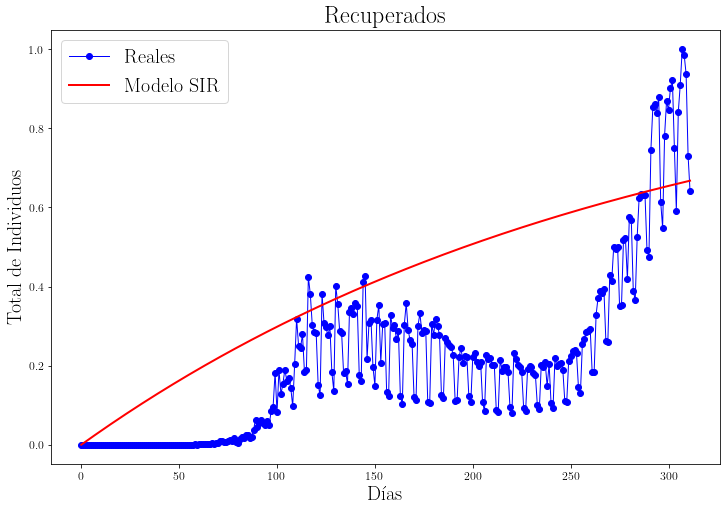

In [93]:
# Gráfica de los recuperados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.R, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, R, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Recuperados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Muertos

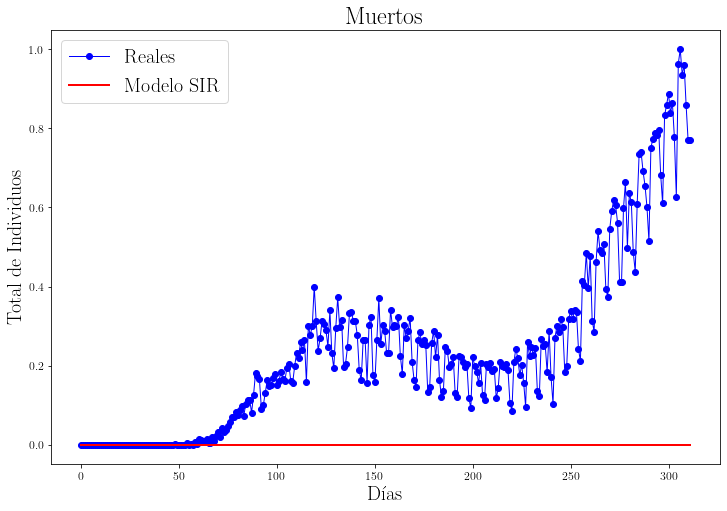

In [94]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.D, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, D, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Muertos')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

# III. Repetiremos todo el procedimiento anterior, pero a un tiempo futuro.

### Carga de Datos (Rusia)

De acuerdo a Google, la población de Rusia es

$$
N = 144.5 \text{ Millones}
$$

In [95]:
# Vamos a considerar la población mundial de Rusia
N = 1445000
# Estos son todos los datos con los que contamos
data = pd.read_csv('Russia_COVID.csv')

# Consideremos el tiempo 0 como el 101 (entrada 100)
Iini = data.iloc[100]["Infectados"]
Rini = data.iloc[100]["Recuperados"] 
Dini = data.iloc[100]["Muertos"]
Sini = N - Iini - Rini - Dini

# VAMOS A TOMAR LOS 100 DATOS MÁS RECIENTES
data = data.iloc[100:200]
data

,Fecha,Tiempo,Infectados_Acumulados,Recuperados_Acumulados,Muertes_Acumulados,Infectados,Recuperados,Muertos
100,5/10/2020,100,209688,34306,1915,11012,2390,88
101,5/11/2020,101,221344,39801,2009,11656,5495,94
102,5/12/2020,102,232243,43512,2116,10899,3711,107
103,5/13/20,103,242271,48003,2212,10028,4491,96
104,5/14/20,104,252245,53530,2305,9974,5527,93
...,...,...,...,...,...,...,...,...
195,8/13/20,195,905762,714934,15353,5017,6034,122
196,8/14/20,196,910778,721473,15467,5016,6539,114
197,8/15/20,197,915808,727895,15585,5030,6422,118
198,8/16/20,198,920719,731444,15653,4911,3549,68


## Defininimos el modelo SIR

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infectado -> Recuperado

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}
\end{align}
$$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

Nota: Este modelo asumirá que $R$ es la población que no que fue infectada pero ya no puede volver a infectar. Por efectos de cómo tenemos los datos, nosotros vamos a considerar que estos serán los muertos más los recuperados.

#### Con infectados y recuperados

In [96]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': range(0,len(data)),
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            'R': data.Muertos + data.Recuperados 
})
datos

,t,I,R
100,0,11012,2478
101,1,11656,5589
102,2,10899,3818
103,3,10028,4587
104,4,9974,5620
...,...,...,...
195,95,5017,6156
196,96,5016,6653
197,97,5030,6540
198,98,4911,3617


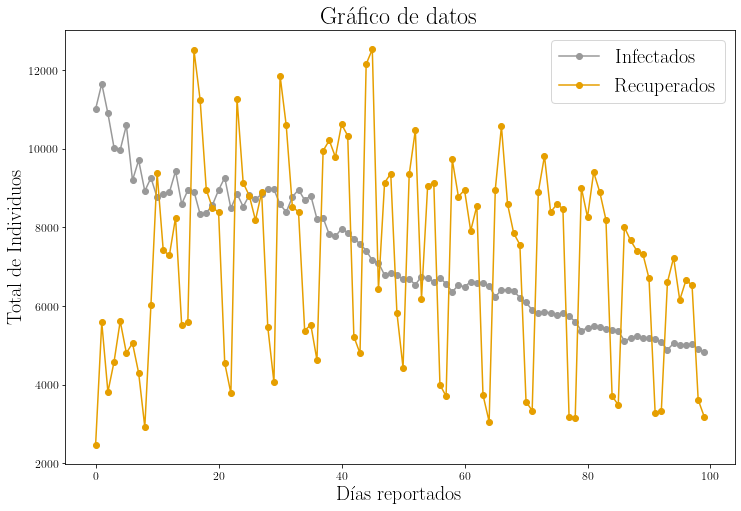

In [97]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [98]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos.

In [99]:
# Susceptible inicial
def S0():
    return Sini
# Infectado inicial
def I0():
    return Iini
# Recuperado inicial
def R0():
    return Rini + Dini

Con base en todo lo anterior, ejectuamos nuestro modelo

In [100]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [101]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([1431510,   11012,    2478], dtype=int64)

##### Encontrando los mejores parámetros

In [102]:
%%time
modelo_SIR.fit()

   $\beta$  $\gamma$
0      0.0   0.00926
Wall time: 2.26 s


In [103]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,0.0,0.00926


In [104]:
modelo_SIR.best_error

5709285.511803529

#### Likelihood profiles

In [105]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 2min 35s


In [106]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,5.709298e+06
1,$\beta$,0.135135,5.084073e+07
2,$\beta$,0.270270,5.183848e+07
3,$\beta$,0.405405,5.286978e+07
4,$\beta$,0.540541,5.396784e+07
...,...,...,...
145,$\gamma$,9.459459,4.990328e+07
146,$\gamma$,9.594595,4.990568e+07
147,$\gamma$,9.729730,4.992812e+07
148,$\gamma$,9.864865,4.990535e+07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


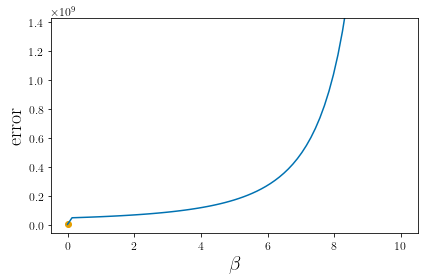

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


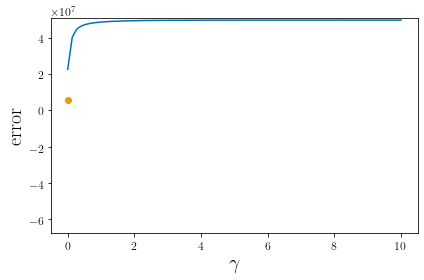

In [107]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales


A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [108]:
# Vector de datos iniciales
iniciales = Sini, Iini, (Rini+Dini)
#t = np.linspace(0, len(datos), len(datos))
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

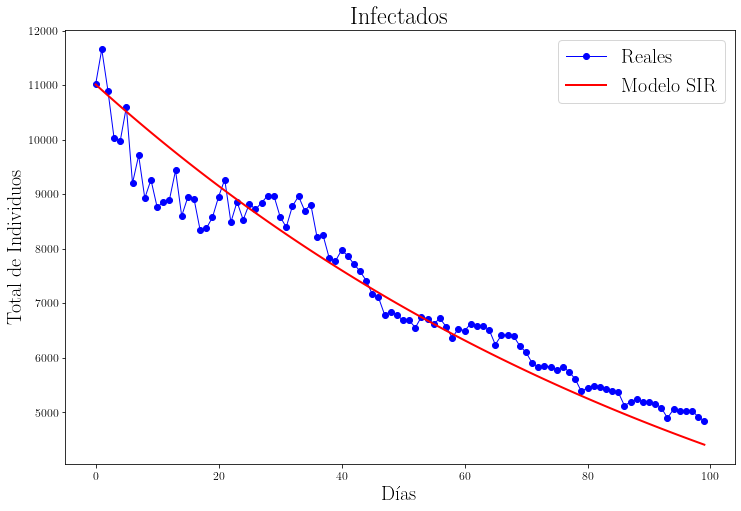

In [109]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Recuperados

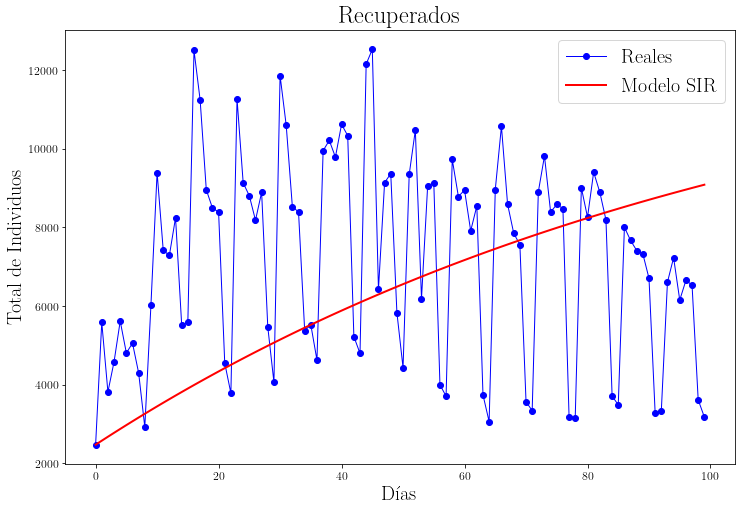

In [110]:
# Gráfica de los recuperados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.R, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, R, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Recuperados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

#### Con infectados únicamente

In [111]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': range(0,len(data)),
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            #'R': data.Muertos + data.Recuperados 
})
datos

,t,I
100,0,11012
101,1,11656
102,2,10899
103,3,10028
104,4,9974
...,...,...
195,95,5017
196,96,5016
197,97,5030
198,98,4911


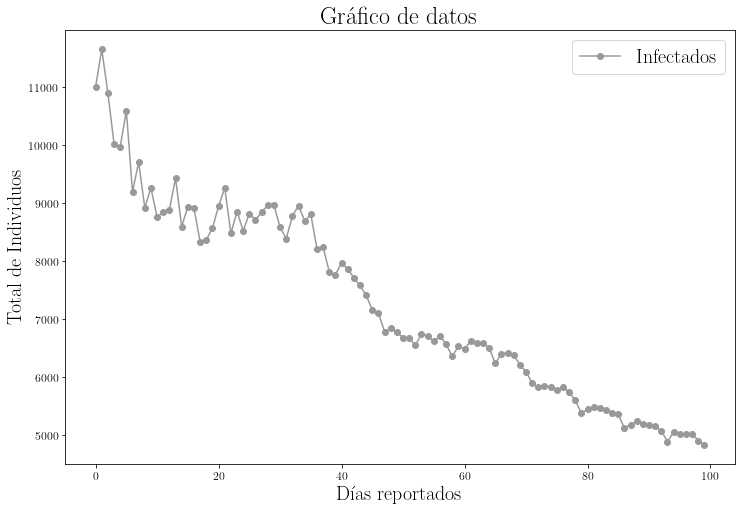

In [112]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
#plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [113]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos.

In [114]:
# Susceptible inicial
def S0():
    return N-Iini-(Rini + Dini)
# Infectado inicial
def I0():
    return Iini
# Recuperado inicial
def R0():
    return Rini + Dini

Con base en todo lo anterior, ejectuamos nuestro modelo

In [115]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [116]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([1431510,   11012,    2478], dtype=int64)

##### Encontrando los mejores parámetros

In [117]:
%%time
modelo_SIR.fit()

   $\beta$  $\gamma$
0      0.0  0.008755
Wall time: 2.11 s


In [118]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,0.0,0.008755


In [119]:
modelo_SIR.best_error

207246.82853780923

#### Likelihood profiles

In [120]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 1min 32s


In [121]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,2.072480e+05
1,$\beta$,0.135135,4.578268e+05
2,$\beta$,0.270270,2.667293e+06
3,$\beta$,0.405405,8.431011e+06
4,$\beta$,0.540541,1.510318e+07
...,...,...,...
145,$\gamma$,9.459459,5.150000e+07
146,$\gamma$,9.594595,5.169754e+07
147,$\gamma$,9.729730,5.194342e+07
148,$\gamma$,9.864865,5.218781e+07


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


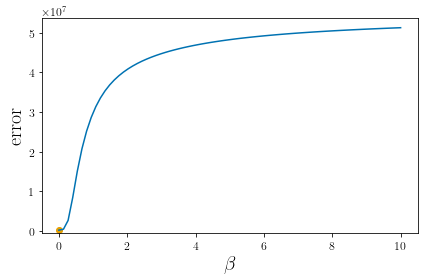

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


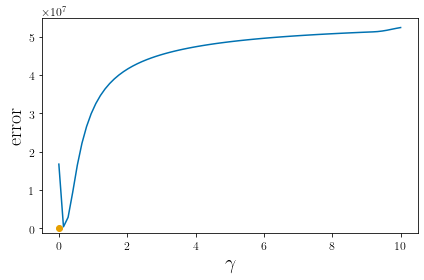

In [122]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [123]:
# Vector de datos iniciales
iniciales = Sini, Iini, (Rini+Dini)
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

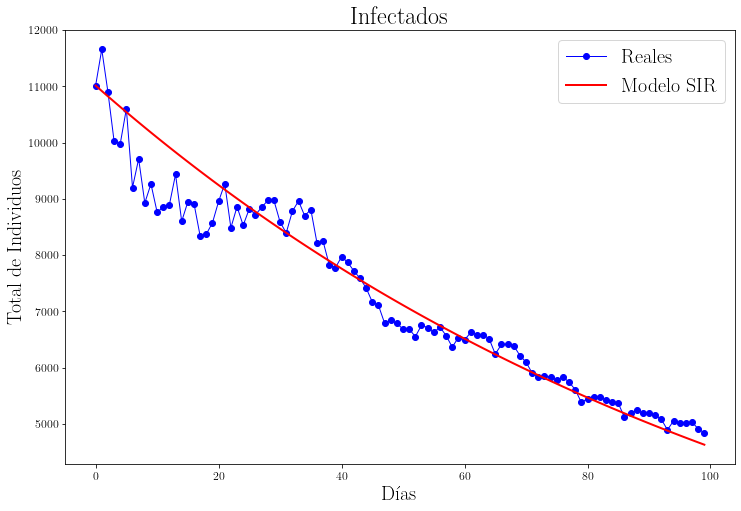

In [124]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

# IV. Repetiremos todo el procedimiento anterior, ahora con los datos más recientes.

### Carga de Datos (Rusia)

De acuerdo a Google, la población de Rusia es

$$
N = 144.5 \text{ Millones}
$$

In [125]:
# Vamos a considerar la población mundial de Rusia
N = 1445000
# Estos son todos los datos con los que contamos
data = pd.read_csv('Russia_COVID.csv')

# Consideremos el tiempo 0 como el 212 (entrada 212)
Iini = data.iloc[212]["Infectados"]
Rini = data.iloc[212]["Recuperados"] 
Dini = data.iloc[212]["Muertos"]
Sini = N - Iini - Rini - Dini

# VAMOS A TOMAR LOS 100 DATOS MÁS RECIENTES
data = data.tail(100)
data

,Fecha,Tiempo,Infectados_Acumulados,Recuperados_Acumulados,Muertes_Acumulados,Infectados,Recuperados,Muertos
212,8/30/20,212,987470,804941,17045,4897,2576,68
213,8/31/20,213,992402,807339,17128,4932,2398,83
214,9/1/2020,214,997072,813603,17250,4670,6264,122
215,9/2/2020,215,1001965,819043,17365,4893,5440,115
216,9/3/2020,216,1006923,824783,17479,4958,5740,114
...,...,...,...,...,...,...,...,...
307,12/3/2020,307,2354934,1843526,41173,27829,29084,543
308,12/4/2020,308,2382012,1872214,41730,27078,28688,557
309,12/5/2020,309,2410462,1899474,42228,28450,27260,498
310,12/6/2020,310,2439163,1920744,42675,28701,21270,447


## Defininimos el modelo SIR

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

Susceptible -> Infectado -> Recuperado

$$
\begin{align}
\beta &= \text{Tasa de contacto } \times \text{Probabilidad de Transmisión}\\
\gamma &= \text{Tasa de Recuperación}
\end{align}
$$

En particular, nosotros vamos a considerar:

- $S :=$ Población susceptible.

- $I :=$ Población Infectada.

- $R :=$ Población Recuperada

Nota: Este modelo asumirá que $R$ es la población que no que fue infectada pero ya no puede volver a infectar. Por efectos de cómo tenemos los datos, nosotros vamos a considerar que estos serán los muertos más los recuperados.

#### Con infectados y recuperados

In [126]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': range(0,len(data)),
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            'R': data.Muertos + data.Recuperados 
})
datos

,t,I,R
212,0,4897,2644
213,1,4932,2481
214,2,4670,6386
215,3,4893,5555
216,4,4958,5854
...,...,...,...
307,95,27829,29627
308,96,27078,29245
309,97,28450,27758
310,98,28701,21717


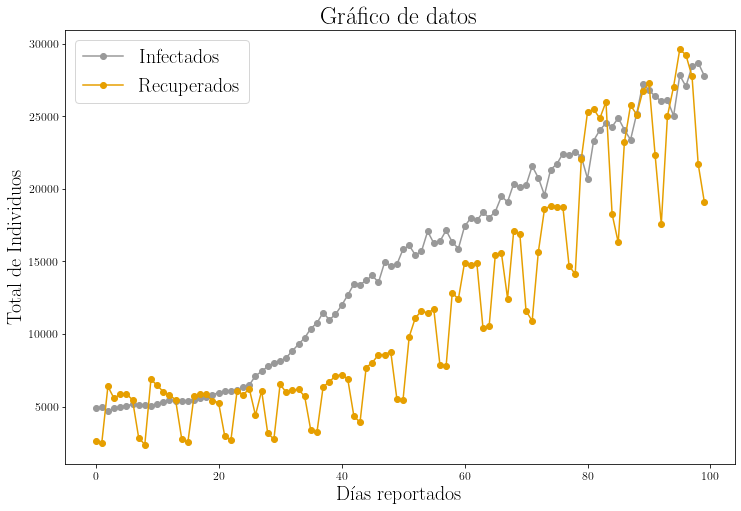

In [127]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [128]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos.

In [129]:
# Susceptible inicial
def S0():
    return Sini
# Infectado inicial
def I0():
    return Iini
# Recuperado inicial
def R0():
    return Rini + Dini

Con base en todo lo anterior, ejectuamos nuestro modelo

In [130]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [131]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([1437459,    4897,    2644], dtype=int64)

##### Encontrando los mejores parámetros

In [132]:
%%time
modelo_SIR.fit()

    $\beta$  $\gamma$
0  0.037249  0.017704
Wall time: 874 ms


In [133]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,0.037249,0.017704


In [134]:
modelo_SIR.best_error

5350842.954427155

#### Likelihood profiles

In [135]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 1min 22s


In [136]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,1.767235e+08
1,$\beta$,0.135135,1.625449e+08
2,$\beta$,0.270270,1.668873e+08
3,$\beta$,0.405405,1.677434e+08
4,$\beta$,0.540541,1.681272e+08
...,...,...,...
145,$\gamma$,9.459459,1.690305e+08
146,$\gamma$,9.594595,1.690278e+08
147,$\gamma$,9.729730,1.690279e+08
148,$\gamma$,9.864865,1.690283e+08


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


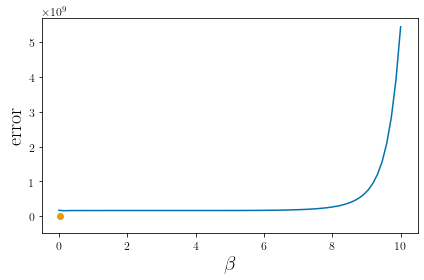

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


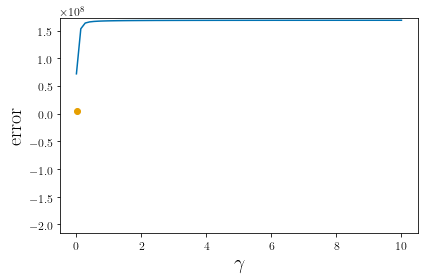

In [137]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales


A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [138]:
# Vector de datos iniciales
iniciales = Sini, Iini, (Rini+Dini)
#t = np.linspace(0, len(datos), len(datos))
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

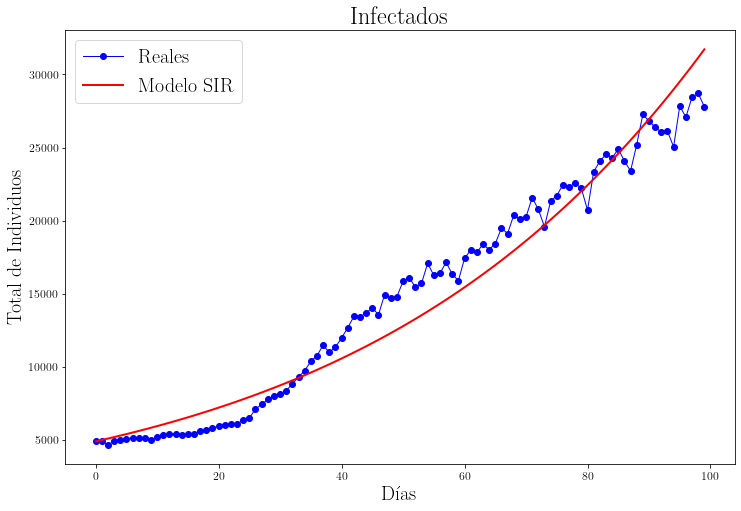

In [139]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

##### Recuperados

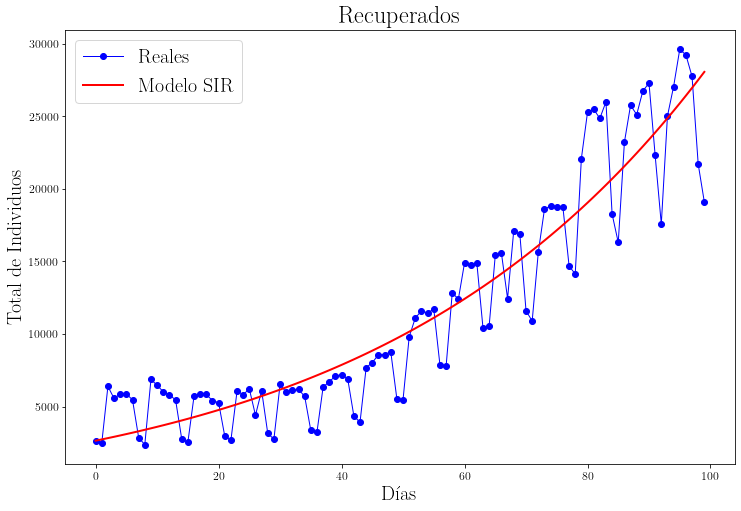

In [140]:
# Gráfica de los recuperados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.R, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, R, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Recuperados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

#### Con infectados únicamente

In [141]:
# En realidad nosotros vamos a ocupar lo siguiente
datos = pd.DataFrame({
            # Tiempo
            't': range(0,len(data)),
            # Susceptibles (vamos a omitirlos pues es un dato que nosotros estamos calculando)
            # 'S': N - np.cumsum(data.Infectados) -  (np.cumsum(data.Recuperados) + np.cumsum(data.Muertos)),
            # Infectados
            'I': data.Infectados,
            # Recuperados (este modelo asume que los recuperados son las personas que ya no pueden contagiar)
            #'R': data.Muertos + data.Recuperados 
})
datos

,t,I
212,0,4897
213,1,4932
214,2,4670
215,3,4893
216,4,4958
...,...,...
307,95,27829
308,96,27078
309,97,28450
310,98,28701


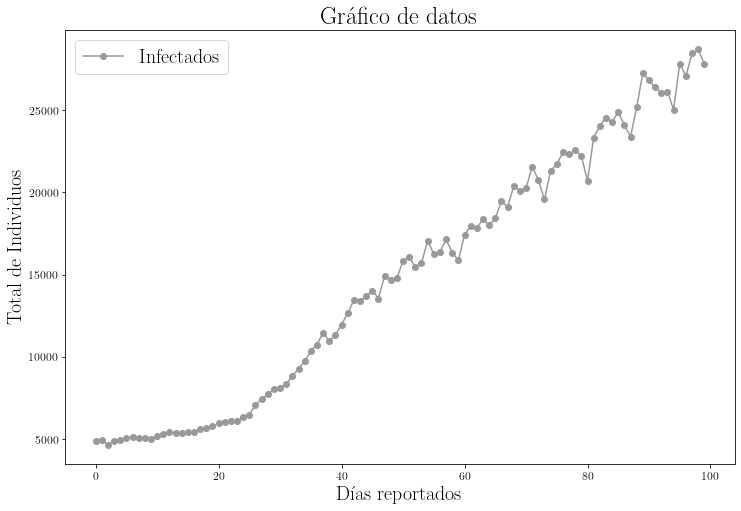

In [142]:
plt.figure(figsize=(12, 8))
plt.title("Gráfico de datos")
plt.plot(datos.t, datos.I, '-o', label="Infectados")
#plt.plot(datos.t, datos.R, '-o', label="Recuperados")
plt.ylabel("Total de Individuos")
plt.xlabel("Días reportados")
plt.legend()

Definimos el sistema de ecuaciones diferenciales a resolver

In [143]:
def sistema_SIR(z, t, beta, gamma):
    
    S, I, R = z
    
    # dS/dt
    dSdt = - beta * S * I / N 
    # dI/dt
    dIdt = beta * S * I / N - gamma * I
    # dR/dt
    dRdt = gamma * I

    
    return [dSdt,dIdt,dRdt]

Vamos a definir los valores iniciales de nuestros datos.

In [144]:
# Susceptible inicial
def S0():
    return N-Iini-(Rini + Dini)
# Infectado inicial
def I0():
    return Iini
# Recuperado inicial
def R0():
    return Rini + Dini

Con base en todo lo anterior, ejectuamos nuestro modelo

In [145]:
modelo_SIR = pde.PDEmodel(datos, sistema_SIR, [S0,I0,R0], bounds=[(0, 10), (0,10)], 
                        param_names=[r'$\beta$', r'$\gamma$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [146]:
# Mostramos la condición Inicial
modelo_SIR.initial_condition

array([1437459,    4897,    2644], dtype=int64)

##### Encontrando los mejores parámetros

In [147]:
%%time
modelo_SIR.fit()

    $\beta$  $\gamma$
0  0.127487   0.10328
Wall time: 1.8 s


In [148]:
modelo_SIR.best_params

,$\beta$,$\gamma$
0,0.127487,0.10328


In [149]:
modelo_SIR.best_error

1077443.0763182635

#### Likelihood profiles

In [150]:
%%time
modelo_SIR.likelihood_profiles(npoints=75)



Wall time: 1min 4s


In [151]:
modelo_SIR.result_profiles

,parameter,value,error
0,$\beta$,0.000000,2.709120e+08
1,$\beta$,0.135135,1.111873e+06
2,$\beta$,0.270270,3.486502e+07
3,$\beta$,0.405405,1.293105e+08
4,$\beta$,0.540541,2.749691e+08
...,...,...,...
145,$\gamma$,9.459459,2.773322e+08
146,$\gamma$,9.594595,2.774263e+08
147,$\gamma$,9.729730,2.774386e+08
148,$\gamma$,9.864865,2.775425e+08


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


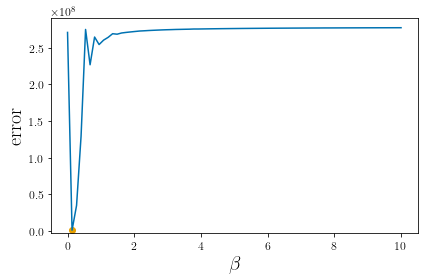

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


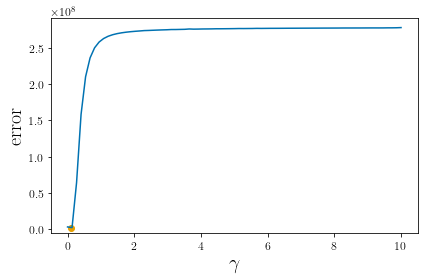

In [152]:
modelo_SIR.plot_profiles()

#### Comparativa de Modelo Vs Datos Reales

A continuación mostraremos los gráficos donde compararemos el modelo obtenido con respecto a los datos que estamos utilizando.

In [153]:
# Vector de datos iniciales
iniciales = Sini, Iini, (Rini+Dini)
t = datos.t
# Extraemos los valores del mejor modelo
beta  = modelo_SIR.best_params.iloc[0,0]
gamma = modelo_SIR.best_params.iloc[0,1]
# Calculamos el modelo SIR con los parámetros dados sobre el periodo de tiempo 't'
ajustados = odeint(sistema_SIR, iniciales, t, args=(beta, gamma))
S, I, R = ajustados.T

##### Infectados

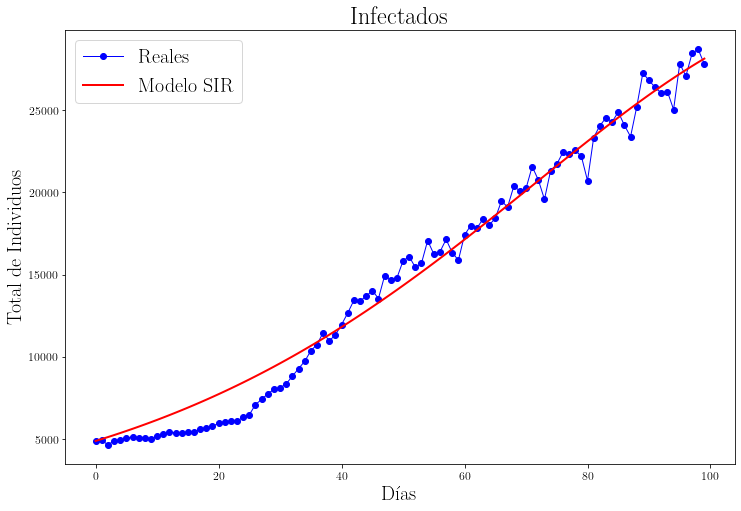

In [154]:
# Gráfica de los infectados
fig = plt.figure(figsize=(12,8))
plt.plot(t, datos.I, '-o', color='b', label='Reales', lw = 1)
plt.plot(t, I, color = 'r', label='Modelo SIR', lw = 2)
plt.title('Infectados')
plt.ylabel('Total de Individuos')
plt.xlabel('Días')
plt.legend()

# Conclusiones

EL algoritmo parece mostrar conflictos cuando los datos tienen 'mucha volatilidad', de tal manera que parece ser más consistente, cuando la trayectoria de los datos parece tener alguna tendencia, lo cual parece brindar a su vez resultados lógicos y razonables. Parece que si se deseara modelar estos datos enteramente, lo más adecuado sería hacerlo por secciones.

### Fuentes
- https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases?force_layout=desktop

- https://www.google.com/search?q=poblacion+total+de+rusia&rlz=1C1CHBF_esMX925MX926&oq=poblacion+total+de+rusia&aqs=chrome..69i57j0j0i22i30l6.3610j0j7&sourceid=chrome&ie=UTF-8

- https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIRD_model

- https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/